# Title: NVD, CVE, STIX, etc
### Purpose: Snippets to explore the MITRE datasets
### Author: @mjz


In [251]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import argparse
import gzip
import os
import json
# import ijson
import platform
import pathlib
import sys
import logging
import re
import urllib.request
from itertools import chain
from jinja2 import Template

import jupyter_core

# from owlready2 import *
# from stix2 import *
# from stix2 import FileSystemSource as fs
# from stix2 import Filter
# from stix2.utils import get_type_from_id


SEP = os.path.sep

sys.path.append('..')

# MulVal Data Loading
# BASE_DIR = '/opt/projects/diss/jupyter_nbs/mine'
BASE_DIR = '/opt/projects/diss/py-mulval'
DATA_DIR = SEP.join((BASE_DIR, 'data'))
WORKING_DIR = SEP.join((DATA_DIR, 'test_004_nvd'))
DOWNLOAD_DIR = SEP.join((WORKING_DIR, 'downloads'))
PROCESSED_DIR = SEP.join((WORKING_DIR, 'processed'))

# logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
# LOG_FILE = SEP.join((WORKING_DIR, '000-nvd_explore.log'))
# logging.basicConfig(
#     level=logging.DEBUG,
#     format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
#     handlers=[
#         logging.FileHandler("{0}/{1}.log".format(WORKING_DIR, '000-nvd_explore')),
#         logging.StreamHandler()
#     ])


CVE_REMOTE_URL = 'http://cve.mitre.org/data/downloads/allitems.csv'
CVE_LOCAL_FILE_NAME_RAW = 'CVE_MITRE_SET.csv'
CVE_LOCAL_FILE_NAME = 'CVE_MITRE_SET.json'
CVE_LOCAL_FILE_RAW = SEP.join((DOWNLOAD_DIR, CVE_LOCAL_FILE_NAME_RAW))
CVE_LOCAL_FILE_PROCESSED = SEP.join((PROCESSED_DIR, CVE_LOCAL_FILE_NAME))

NVD_SCHEMA_REMOTE_URL = 'https://csrc.nist.gov/schema/nvd/feed/1.1/nvd_cve_feed_json_1.1.schema'

NVD_REMOTE_JSON_FEED_LIST = 'https://nvd.nist.gov/vuln/data-feeds#JSON_FEED'
NVD_REMOTE_JSON_FEED_BASE = 'https://nvd.nist.gov/feeds/json/cve/1.1'
NVD_REMOTE_JSON_FILE_PATTERN = r'(nvdcve-1\.1-[0-9]*?\.json\.gz)'  # only pull yearly files
NVD_LOCAL_FILE_NAME = 'nist_nvd.json'
NVD_LOCAL_FILE = SEP.join((PROCESSED_DIR, NVD_LOCAL_FILE_NAME))


# NVD_REMOTE_JSON_FILE_PATTERN = r'(nvdcve-1\.1-[a-zA-Z0-9]*?\.json\.gz)' #  pull modified and recent as well


class mitre_cve(object):
  def __init__(self, *args, **kwargs):
    super(mitre_cve, self)

  def get_cves_from_mitre(self):
    cve_raw = pathlib.Path(CVE_LOCAL_FILE_RAW)

    if not cve_raw.exists():
      logging.debug('downloading cve_raw: %s' % CVE_LOCAL_FILE_RAW)
      urllib.request.urlretrieve(CVE_REMOTE_URL, CVE_LOCAL_FILE_RAW)
    else:
      logging.debug('cve_raw already exists: %s' % CVE_LOCAL_FILE_RAW)

  def convert_cves_to_json(self):
    cve_raw = pathlib.Path(CVE_LOCAL_FILE_NAME_RAW)
    cve_json = pathlib.Path(CVE_LOCAL_FILE_PROCESSED)
    if not cve_json.exists():
      logging.debug('writing cve_json: %s' % CVE_LOCAL_FILE_PROCESSED)
      cve_df = pd.read_csv(cve_raw, sep=',', quotechar='"', header=2,
                           skiprows=range(3, 10), encoding="ISO-8859-1")
      cve_df.to_csv(CVE_LOCAL_FILE_PROCESSED)
    else:
      logging.debug('cve_json already exists: %s' % CVE_LOCAL_FILE_PROCESSED)


class nist_nvd(object):

  def __init__(self, *args, **kwargs):
    super(nist_nvd, self)

    self.nvd_file_list = list()

  def get_nvd_from_nist(self):

    #  download NVD yearly feeds if they don't exist
    feed_list = urllib.request.urlopen(NVD_REMOTE_JSON_FEED_LIST)
    response = feed_list.read()
    for filename in re.findall(NVD_REMOTE_JSON_FILE_PATTERN, str(response)):
      self.nvd_file_list.append(filename)
      outfile_name = SEP.join(((DOWNLOAD_DIR, filename)))
      outfile = pathlib.Path(outfile_name)
      if not outfile.exists():
        logging.debug('downloading nvd_file: %s' % outfile_name)
        urllib.request.urlretrieve(
            '/'.join((NVD_REMOTE_JSON_FEED_BASE, filename)), outfile)
      else:
        logging.debug('found nvd file %s, skipping download...' % outfile)

    logging.debug(self.nvd_file_list)

  def write_nvd_to_json(self, overwrite_if_exists=False):
    outfile = pathlib.Path(NVD_LOCAL_FILE)
    cve_dfs = []
    date_cols = ['publishedDate',
                 'lastModifiedDate']
    bool_cols = ['impact.baseMetricV2.acInsufInfo',
                 'impact.baseMetricV2.obtainAllPrivilege',
                 'impact.baseMetricV2.obtainUserPrivilege',
                 'impact.baseMetricV2.obtainOtherPrivilege',
                 'impact.baseMetricV2.userInteractionRequired']
    category_cols = [
      'cve.data_type',
      'cve.data_format',
      'cve.data_version',
      'cve.CVE_data_meta.ASSIGNER',
      'configurations.CVE_data_version',
      'impact.baseMetricV3.cvssV3.version',
      #        'impact.baseMetricV3.cvssV3.vectorString',
      'impact.baseMetricV3.cvssV3.attackVector',
      'impact.baseMetricV3.cvssV3.attackComplexity',
      'impact.baseMetricV3.cvssV3.privilegesRequired',
      'impact.baseMetricV3.cvssV3.userInteraction',
      'impact.baseMetricV3.cvssV3.scope',
      'impact.baseMetricV3.cvssV3.confidentialityImpact',
      'impact.baseMetricV3.cvssV3.integrityImpact',
      'impact.baseMetricV3.cvssV3.availabilityImpact',
      'impact.baseMetricV3.cvssV3.baseSeverity',
      'impact.baseMetricV2.cvssV2.version',
      #        'impact.baseMetricV2.cvssV2.vectorString',
      'impact.baseMetricV2.cvssV2.accessVector',
      'impact.baseMetricV2.cvssV2.accessComplexity',
      'impact.baseMetricV2.cvssV2.authentication',
      'impact.baseMetricV2.cvssV2.confidentialityImpact',
      'impact.baseMetricV2.cvssV2.integrityImpact',
      'impact.baseMetricV2.cvssV2.availabilityImpact',
      'impact.baseMetricV2.severity',
    ]

    if not outfile.exists() or overwrite_if_exists:
      logging.debug('writing nist_nvd to json: %s...' % NVD_LOCAL_FILE)
      for gzip_file in self.nvd_file_list:
        year_df = pd.read_json(SEP.join((DOWNLOAD_DIR, gzip_file)))
        cve_dfs.append(json_normalize(year_df['CVE_Items']))
      cve_df = pd.concat(cve_dfs, sort=False)
      for col in cve_df.columns:
        print(col)
      cve_df = cve_df.set_index(['cve.CVE_data_meta.ID'])
      cve_df[bool_cols] = cve_df[bool_cols].astype(bool)
      cve_df[category_cols] = cve_df[category_cols].astype('category')
      # 'table="orient" can not yet read timezone ' "data")
      # cve_df[date_cols] = cve_df[date_cols].apply(pd.to_datetime)
      print(cve_df.info())
      cve_df.to_json(NVD_LOCAL_FILE, orient='table')
    else:
      logging.debug('found nvd_nist file at: %s' % NVD_LOCAL_FILE)

  def read_nvd_from_json(self, *args, **kwargs):
    date_cols = ['publishedDate', 'lastModifiedDate']

    # raise NotImplementedError('table="orient" can not yet read timezone ' "data")
    return pd.read_json(NVD_LOCAL_FILE, convert_dates=date_cols, orient='table')
    # return pd.read_json(NVD_LOCAL_FILE, orient='table')


def setup():
  dirs = [WORKING_DIR, DOWNLOAD_DIR, PROCESSED_DIR]

  logging.basicConfig(
      level=logging.DEBUG,
      format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
      handlers=[
        logging.FileHandler(
            "{0}/{1}.log".format(WORKING_DIR, '000-nvd_explore')),
        logging.StreamHandler()
      ])

  for dir in dirs:
    # logging.debug(('creating working directory: %s') % (WORKING_DIR))
    path = pathlib.Path(dir)
    if not path.exists():
      logging.debug('%s doesnt exist, creating...' % path)
      path.mkdir(parents=True, exist_ok=True)
    else:
      logging.debug('%s already exists, skipping...' % path)



In [286]:
print(pd.__version__)
print(np.__version__)

setup()  # configure logging, create dirs, ...

os.chdir(WORKING_DIR)

cve = mitre_cve()
cve.get_cves_from_mitre()
# cve.write_cves_to_json()
cve.write_cves_to_json(overwrite_if_exists=True)
cve_df = cve.read_cves_from_json()
print(cve_df.describe())
print(cve_df.info())
print(cve_df.head())

nvd = nist_nvd()
nvd.get_nvd_from_nist()
# nvd.write_nvd_to_json(overwrite_if_exists=True)
nvd.write_nvd_to_json()
nvd_df = nvd.read_nvd_from_json()


v2_cols = {'impact.baseMetricV2.cvssV2.version' : 'v2.version',
            'impact.baseMetricV2.cvssV2.vectorString' : 'v2.vectorString',
            'impact.baseMetricV2.cvssV2.accessVector': 'v2.accessVector',
            'impact.baseMetricV2.cvssV2.accessComplexity': 'v2.accessComplexity',
            'impact.baseMetricV2.cvssV2.authentication': 'v2.authentication',
            'impact.baseMetricV2.cvssV2.confidentialityImpact': 'v2.confidentialityImpact',
            'impact.baseMetricV2.cvssV2.integrityImpact': 'v2.integrityImpact',
            'impact.baseMetricV2.cvssV2.availabilityImpact': 'v2.availabilityImpact',
            'impact.baseMetricV2.cvssV2.baseScore': 'v2.baseScore', 
            'impact.baseMetricV2.severity': 'v2.severity',
            'impact.baseMetricV2.exploitabilityScore': 'v2,exploitabilityScore',
            'impact.baseMetricV2.impactScore': 'v2.impactScore', 
            'impact.baseMetricV2.acInsufInfo': 'v2.acInsufInfo',
            'impact.baseMetricV2.obtainAllPrivilege': 'v2.obtainAllPrivilege',
            'impact.baseMetricV2.obtainUserPrivilege': 'v2.obtainUserPrivilege',
            'impact.baseMetricV2.obtainOtherPrivilege': 'v2.obtainOtherPrivilege',
            'impact.baseMetricV2.userInteractionRequired': 'v2.userInteractionRequired'}

v3_cols = {'impact.baseMetricV3.cvssV3.version' : 'v3.version',
           'impact.baseMetricV3.cvssV3.vectorString': 'v3.vectorString',
           'impact.baseMetricV3.cvssV3.attackVector': 'v3.attackVector',
           'impact.baseMetricV3.cvssV3.attackComplexity': 'v3.attackComplexity',
           'impact.baseMetricV3.cvssV3.privilegesRequired': 'v3.privilegesRequired',
           'impact.baseMetricV3.cvssV3.userInteraction': 'v3.userInteraction',
           'impact.baseMetricV3.cvssV3.scope': 'v3.scope',
           'impact.baseMetricV3.cvssV3.confidentialityImpact': 'v3.confidentialityImpact',
           'impact.baseMetricV3.cvssV3.integrityImpact': 'v3.integrityImpact',
           'impact.baseMetricV3.cvssV3.availabilityImpact': 'v3.availabilityImpact',
           'impact.baseMetricV3.cvssV3.baseScore': 'v3.baseScore',
           'impact.baseMetricV3.cvssV3.baseSeverity': 'v3.baseSeverity',
           'impact.baseMetricV3.exploitabilityScore': 'v3.exploitabilityScore',
           'impact.baseMetricV3.impactScore': 'v3.impactScore', }

common_cols = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes',]

# make easy names
nvd_df = nvd_df.rename(columns={**v2_cols, **v3_cols})

print(nvd_df.describe())
print(nvd_df.info())
print(nvd_df.head())

nvd_df.describe()

0.25.3
1.17.4


/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


                 Name     Status  \
count          163289     163289   
unique         163289          2   
top     CVE-2020-2450  Candidate   
freq                1     160236   

                                              Description  \
count                                              163289   
unique                                             125691   
top     ** RESERVED ** This candidate has been reserve...   
freq                                                19865   

                                               References  \
count                                              127420   
unique                                             111006   
top     BID:103671   |   URL:http://www.securityfocus....   
freq                                                  262   

                      Phase                              Votes  \
count                160236                             160236   
unique                 4821                               1289   
top     A

,v3.baseScore,v3.exploitabilityScore,v3.impactScore,v2.baseScore,"v2,exploitabilityScore",v2.impactScore
count,53495.000000,53495.000000,53495.000000,127030.000000,127030.000000,127030.000000
mean,7.287006,2.738131,4.410134,6.064273,8.216265,5.609347
std,1.632053,0.926520,1.491768,2.010822,2.140168,2.644161
min,1.800000,0.100000,1.400000,0.000000,1.200000,0.000000
25%,6.100000,1.800000,3.600000,4.300000,8.000000,2.900000
50%,7.500000,2.800000,3.600000,5.800000,8.600000,6.400000
75%,8.800000,3.900000,5.900000,7.500000,10.000000,6.400000
max,10.000000,3.900000,6.000000,10.000000,10.000000,10.000000


# CVE

In [277]:
# cve_df.set_index('Name')
cve_df.columns

Index(['Name', 'Status', 'Description', 'References', 'Phase', 'Votes',
       'Comments'],
      dtype='object')

In [254]:
cve_df.describe()

,Name,Status,Description,References,Phase,Votes,Comments
count,163289,163289,163289,127420,160236,160236,1855
unique,163289,2,125691,111006,4821,1289,1774
top,CVE-2020-2450,Candidate,** RESERVED ** This candidate has been reserve...,BID:103671 | URL:http://www.securityfocus....,Assigned (20190103),None (candidate not yet proposed),Cole> See comments for CVE-2000-0101 | Fre...
freq,1,160236,19865,262,1436,157310,11


# CVSS / NVD

https://avleonov.com/2017/10/03/downloading-and-analyzing-nvd-cve-feed/



In [287]:
print(nvd_df.shape)
print('=========')
print(nvd_df.describe())

(134770, 42)
       v3.baseScore  v3.exploitabilityScore  v3.impactScore   v2.baseScore  \
count  53495.000000            53495.000000    53495.000000  127030.000000   
mean       7.287006                2.738131        4.410134       6.064273   
std        1.632053                0.926520        1.491768       2.010822   
min        1.800000                0.100000        1.400000       0.000000   
25%        6.100000                1.800000        3.600000       4.300000   
50%        7.500000                2.800000        3.600000       5.800000   
75%        8.800000                3.900000        5.900000       7.500000   
max       10.000000                3.900000        6.000000      10.000000   

       v2,exploitabilityScore  v2.impactScore  
count           127030.000000   127030.000000  
mean                 8.216265        5.609347  
std                  2.140168        2.644161  
min                  1.200000        0.000000  
25%                  8.000000        2.90000

In [288]:
print(nvd_df.dtypes)
print('===========')
print(nvd_df.info())

publishedDate                       datetime64[ns, UTC]
lastModifiedDate                    datetime64[ns, UTC]
cve.data_type                                  category
cve.data_format                                category
cve.data_version                               category
cve.CVE_data_meta.ASSIGNER                     category
cve.problemtype.problemtype_data                 object
cve.references.reference_data                    object
cve.description.description_data                 object
configurations.CVE_data_version                category
configurations.nodes                             object
v3.version                                     category
v3.vectorString                                  object
v3.attackVector                                category
v3.attackComplexity                            category
v3.privilegesRequired                          category
v3.userInteraction                             category
v3.scope                                       c

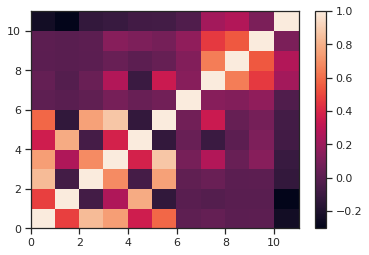

In [398]:
# nvd_df.sort_values(by=["impact.baseMetricV2.cvssV2.baseScore","impact.baseMetricV2.exploitabilityScore",])


# vars_to_use = ['impact.baseMetricV2.cvssV2.baseScore', 
#                'impact.baseMetricV2.severity', 
#                'impact.baseMetricV2.obtainAllPrivilege', 
#                'impact.baseMetricV2.userInteractionRequired', 
#               'impact.baseMetricV3.cvssV3.baseScore',
#               'impact.baseMetricV2.obtainUserPrivilege'] # pick vars

# vars_to_use = ['v2.baseScore', 
#                'v2.severity', 
#                'v2.obtainAllPrivilege', 
#                'v2.userInteractionRequired', 
#               'v3.baseScore',
#               'v2.obtainUserPrivilege'] # pick vars

vars_to_use = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes', 'v3.version', 'v3.vectorString',
       'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
       'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
       'v3.integrityImpact', 'v3.availabilityImpact', 'v3.baseScore',
       'v3.baseSeverity', 'v3.exploitabilityScore', 'v3.impactScore',
       'v2.version', 'v2.vectorString', 'v2.accessVector',
       'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
       'v2.integrityImpact', 'v2.availabilityImpact', 'v2.baseScore',
       'v2.severity', 'v2,exploitabilityScore', 'v2.impactScore',
       'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
       'v2.obtainOtherPrivilege', 'v2.userInteractionRequired']

plt.pcolor(nvd_df[vars_to_use].corr()) # do the feature correlation plot

# fill in the indices
# plt.yticks(np.arange(len(vars_to_use)), vars_to_use)
# plt.xticks(np.arange(len(vars_to_use)), vars_to_use)
plt.colorbar()
plt.show()

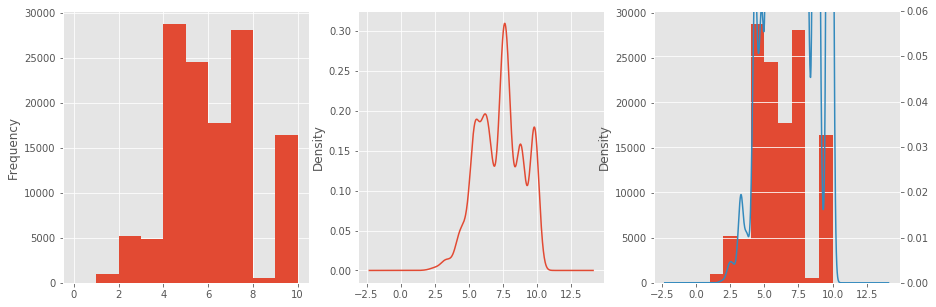

In [295]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
nvd_df['v2.baseScore'].plot.hist(bins=10)

plt.subplot(1,3,2)
nvd_df['v3.baseScore'].plot.kde(bw_method=0.2)

plt.subplot(1,3,3)
nvd_df['v2.baseScore'].plot.hist(bins=10)
nvd_df['v3.baseScore'].plot.kde(bw_method=0.1, secondary_y=True)
plt.ylim([0, 0.06])

plt.show()

In [296]:
nvd_df.columns

Index(['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes', 'v3.version', 'v3.vectorString',
       'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
       'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
       'v3.integrityImpact', 'v3.availabilityImpact', 'v3.baseScore',
       'v3.baseSeverity', 'v3.exploitabilityScore', 'v3.impactScore',
       'v2.version', 'v2.vectorString', 'v2.accessVector',
       'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
       'v2.integrityImpact', 'v2.availabilityImpact', 'v2.baseScore',
       'v2.severity', 'v2,exploitabilityScore', 'v2.impactScore',
       'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
       'v2.o

In [298]:
nvd_df['v3.privilegesRequired'].describe()

count     53495
unique        3
top        NONE
freq      37420
Name: v3.privilegesRequired, dtype: object

In [400]:
v2_cols = {'impact.baseMetricV2.cvssV2.version' : 'v2.version',
            'impact.baseMetricV2.cvssV2.vectorString' : 'v2.vectorString',
            'impact.baseMetricV2.cvssV2.accessVector': 'v2.accessVector',
            'impact.baseMetricV2.cvssV2.accessComplexity': 'v2.accessComplexity',
            'impact.baseMetricV2.cvssV2.authentication': 'v2.authentication',
            'impact.baseMetricV2.cvssV2.confidentialityImpact': 'v2.confidentialityImpact',
            'impact.baseMetricV2.cvssV2.integrityImpact': 'v2.integrityImpact',
            'impact.baseMetricV2.cvssV2.availabilityImpact': 'v2.availabilityImpact',
            'impact.baseMetricV2.cvssV2.baseScore': 'v2.baseScore', 
            'impact.baseMetricV2.severity': 'v2.severity',
            'impact.baseMetricV2.exploitabilityScore': 'v2,exploitabilityScore',
            'impact.baseMetricV2.impactScore': 'v2.impactScore', 
            'impact.baseMetricV2.acInsufInfo': 'v2.acInsufInfo',
            'impact.baseMetricV2.obtainAllPrivilege': 'v2.obtainAllPrivilege',
            'impact.baseMetricV2.obtainUserPrivilege': 'v2.obtainUserPrivilege',
            'impact.baseMetricV2.obtainOtherPrivilege': 'v2.obtainOtherPrivilege',
            'impact.baseMetricV2.userInteractionRequired': 'v2.userInteractionRequired`'}

v3_cols = {'impact.baseMetricV3.cvssV3.version' : 'v3.version',
           'impact.baseMetricV3.cvssV3.vectorString': 'v3.vectorString',
           'impact.baseMetricV3.cvssV3.attackVector': 'v3.attackVector',
           'impact.baseMetricV3.cvssV3.attackComplexity': 'v3.attackComplexity',
           'impact.baseMetricV3.cvssV3.privilegesRequired': 'v3.privilegesRequired',
           'impact.baseMetricV3.cvssV3.userInteraction': 'v3.userInteraction',
           'impact.baseMetricV3.cvssV3.scope': 'v3.scope',
           'impact.baseMetricV3.cvssV3.confidentialityImpact': 'v3.confidentialityImpact',
           'impact.baseMetricV3.cvssV3.integrityImpact': 'v3.integrityImpact',
           'impact.baseMetricV3.cvssV3.availabilityImpact': 'v3.availabilityImpact',
           'impact.baseMetricV3.cvssV3.baseScore': 'v3.baseScore',
           'impact.baseMetricV3.cvssV3.baseSeverity': 'v3.baseSeverity',
           'impact.baseMetricV3.exploitabilityScore': 'v3.exploitabilityScore',
           'impact.baseMetricV3.impactScore': 'v3.impactScore', }

common_cols = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes',]

nvd_df = nvd_df.rename(columns={**v2_cols, **v3_cols})
nvd_df.describe()


,v3.baseScore,v3.exploitabilityScore,v3.impactScore,v2.baseScore,"v2,exploitabilityScore",v2.impactScore
count,53495.000000,53495.000000,53495.000000,127030.000000,127030.000000,127030.000000
mean,7.287006,2.738131,4.410134,6.064273,8.216265,5.609347
std,1.632053,0.926520,1.491768,2.010822,2.140168,2.644161
min,1.800000,0.100000,1.400000,0.000000,1.200000,0.000000
25%,6.100000,1.800000,3.600000,4.300000,8.000000,2.900000
50%,7.500000,2.800000,3.600000,5.800000,8.600000,6.400000
75%,8.800000,3.900000,5.900000,7.500000,10.000000,6.400000
max,10.000000,3.900000,6.000000,10.000000,10.000000,10.000000


In [401]:
nvd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134770 entries, CVE-2019-0001 to CVE-2002-2446
Data columns (total 42 columns):
publishedDate                       134770 non-null datetime64[ns, UTC]
lastModifiedDate                    134770 non-null datetime64[ns, UTC]
cve.data_type                       134770 non-null category
cve.data_format                     134770 non-null category
cve.data_version                    134770 non-null category
cve.CVE_data_meta.ASSIGNER          134770 non-null category
cve.problemtype.problemtype_data    134770 non-null object
cve.references.reference_data       134770 non-null object
cve.description.description_data    134770 non-null object
configurations.CVE_data_version     134770 non-null category
configurations.nodes                134770 non-null object
v3.version                          53495 non-null category
v3.vectorString                     53495 non-null object
v3.attackVector                     53495 non-null category
v3.attackCom

In [323]:
# df_grouped = nvd_df.groupby(by=[
#        'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
#        'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
#        'v3.integrityImpact', 'v3.availabilityImpact',
#        'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
#        'v2.integrityImpact', 'v2.availabilityImpact',
#        'v2.severity',
#        'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
#        'v2.obtainOtherPrivilege', 'v2.userInteractionRequired'])

df_grouped = nvd_df.groupby(by=[
       'v2.accessVector', 'v2.obtainAllPrivilege'])
# df_grouped = nvd_df.groupby(by=[
#        'v3.attackVector', 'v2.obtainAllPrivilege'])
# print (df_grouped.describe())

In [325]:
df_grouped.describe()

v3.baseScore                           \
                                              count      mean       std  min   
v2.accessVector  v2.obtainAllPrivilege                                         
ADJACENT_NETWORK False                        836.0  7.011364  1.505885  2.4   
                 True                           2.0  8.400000  0.565685  8.0   
LOCAL            False                       7281.0  6.583546  1.451986  1.8   
                 True                          62.0  7.609677  0.623504  6.7   
NETWORK          False                      45235.0  7.401651  1.633034  2.0   
                 True                          79.0  9.111392  0.859634  7.2   

                                                             \
                                        25%  50%  75%   max   
v2.accessVector  v2.obtainAllPrivilege                        
ADJACENT_NETWORK False                  6.5  6.8  8.4   9.8   
                 True                   8.2  8.4  8.6   8.8   
LOCAL            False                  5.5  7.0  7.8   9.8   
                 True                   7.0  7.8  7.8   9.8   
NETWORK          False                  6.1  7.5  8.8  10.0   
                 True                   8.8  9.8  9.8  10.0   

                                       v3.exploitabilityScore            \
                                                        count      mean   
v2.accessVector  v2.obtainAllPrivilege                                    
ADJACENT_NETWORK False                                  836.0  2.345574   
                 True                                     2.0  2.450000   
LOCAL            False                                 7281.0  1.588999   
                 True                                    62.0  1.572581   
NETWORK          False                                45235.0  2.931239   
                 True                                    79.0  3.150633   

                                                                           \
                                             std  min    25%   50%    75%   
v2.accessVector  v2.obtainAllPrivilege                                      
ADJACENT_NETWORK False                  0.627430  0.4  2.025  2.80  2.800   
                 True                   0.494975  2.1  2.275  2.45  2.625   
LOCAL            False                  0.436011  0.1  1.300  1.80  1.800   
                 True                   0.536891  0.8  1.000  1.80  1.800   
NETWORK          False                  0.848982  0.3  2.300  2.80  3.900   
                 True                   0.872643  1.2  2.800  3.90  3.900   

                                            v3.impactScore            \
                                        max          count      mean   
v2.accessVector  v2.obtainAllPrivilege                                 
ADJACENT_NETWORK False                  3.9          836.0  4.517943   
                 True                   2.8            2.0  5.900000   
LOCAL            False                  3.9         7281.0  4.861503   
                 True                   3.9           62.0  5.908065   
NETWORK          False                  3.9        45235.0  4.330762   
                 True                   3.9           79.0  5.903797   

                                                                           \
                                             std  min  25%  50%  75%  max   
v2.accessVector  v2.obtainAllPrivilege                                      
ADJACENT_NETWORK False                  1.400766  1.4  3.6  4.0  5.9  6.0   
                 True                   0.000000  5.9  5.9  5.9  5.9  5.9   
LOCAL            False                  1.361213  1.4  3.6  5.9  5.9  6.0   
                 True                   0.027451  5.9  5.9  5.9  5.9  6.0   
NETWORK          False                  1.500311  1.4  3.6  3.6  5.9  6.0   
                 True                   0.019236  5.9  5.9  5.9  5.9  6.0   

                                     

In [402]:
print(nvd_df['v3.attackVector'].cat.categories)
print(nvd_df['v2.accessVector'].cat.categories)

Index(['ADJACENT_NETWORK', 'LOCAL', 'NETWORK', 'PHYSICAL'], dtype='object')
Index(['ADJACENT_NETWORK', 'LOCAL', 'NETWORK'], dtype='object')


In [403]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

print('Seaborn:', sns. __version__)


Seaborn: 0.9.0


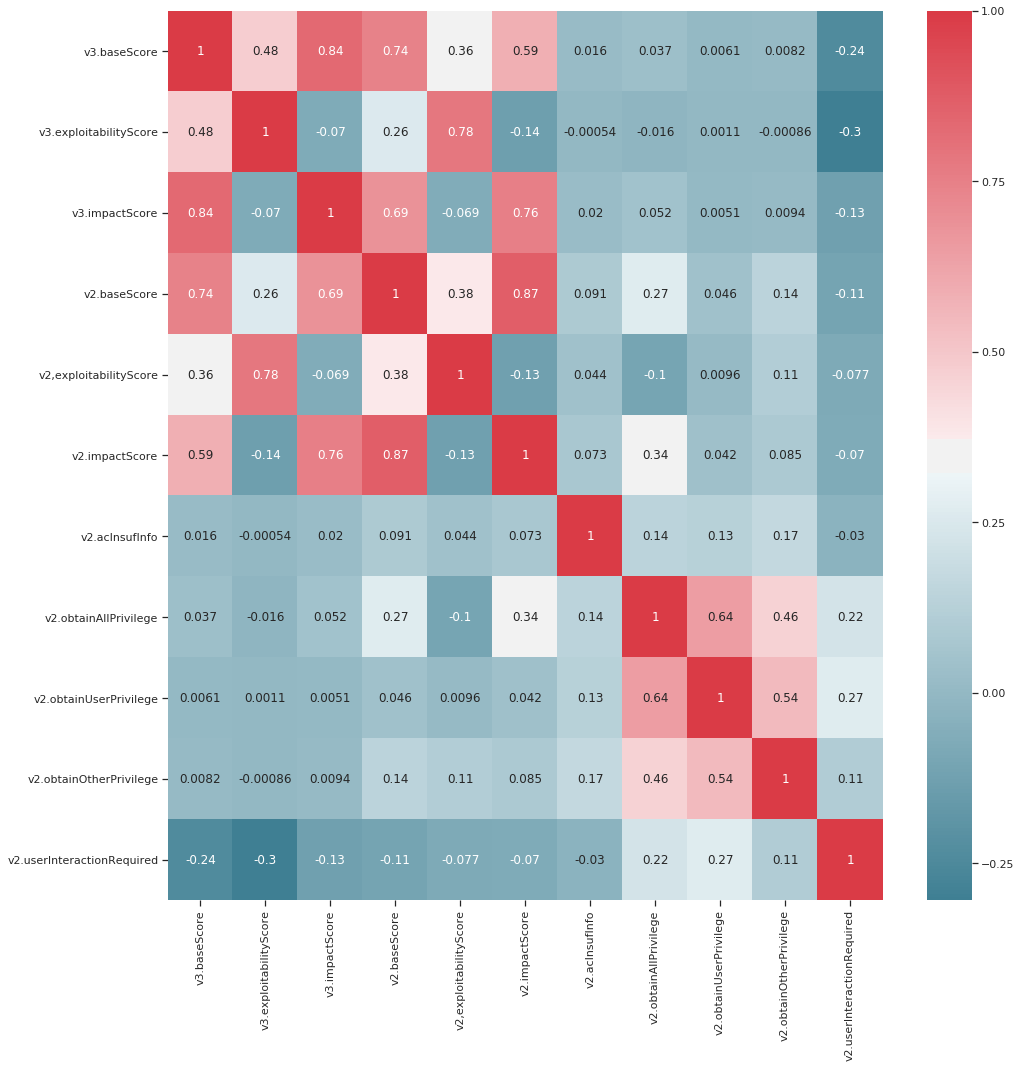

In [404]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nvd_df.corr(), cmap=cmap, annot=True)

f.tight_layout()

In [365]:
# nvd_df.columns.to_series().groupby(nvd_df.dtypes).groups

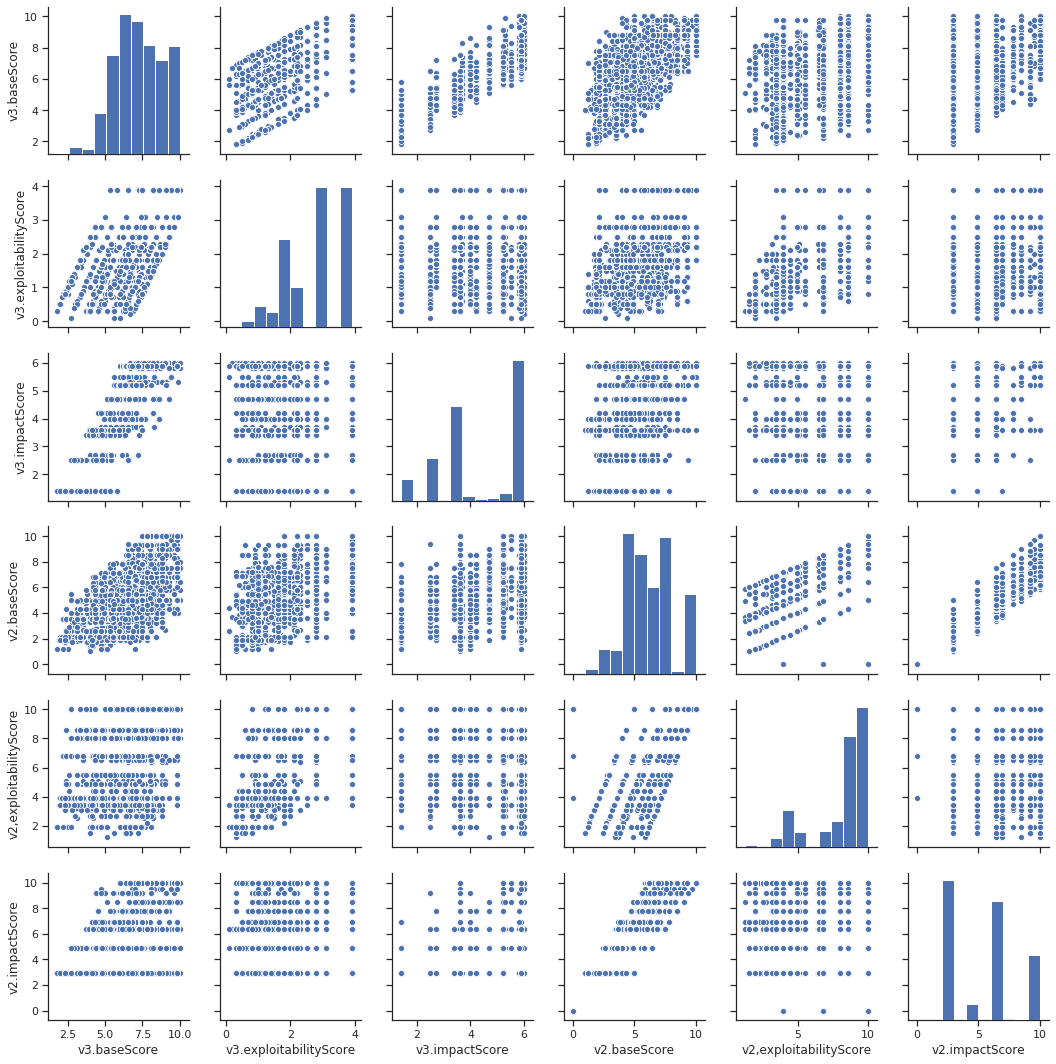

In [432]:
# sns.pairplot(nvd_df, hue="v3.attackVector", size=2,
#             plot_kws=dict(s=20, alpha=0.15, linewidth=0))
# df = 
sns.pairplot(nvd_df.select_dtypes(include=['float']), )

plt.show()

In [410]:
nvd_df.columns

Index(['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes', 'v3.version', 'v3.vectorString',
       'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
       'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
       'v3.integrityImpact', 'v3.availabilityImpact', 'v3.baseScore',
       'v3.baseSeverity', 'v3.exploitabilityScore', 'v3.impactScore',
       'v2.version', 'v2.vectorString', 'v2.accessVector',
       'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
       'v2.integrityImpact', 'v2.availabilityImpact', 'v2.baseScore',
       'v2.severity', 'v2,exploitabilityScore', 'v2.impactScore',
       'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
       'v2.o

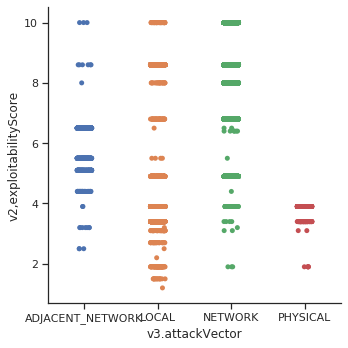

In [411]:
sns.set(style="ticks", color_codes=True)

# sns.pairplot(nvd_df.select_dtypes(include=['float']),)

sns.catplot(x='v3.attackVector', y='v2,exploitabilityScore', data=nvd_df)

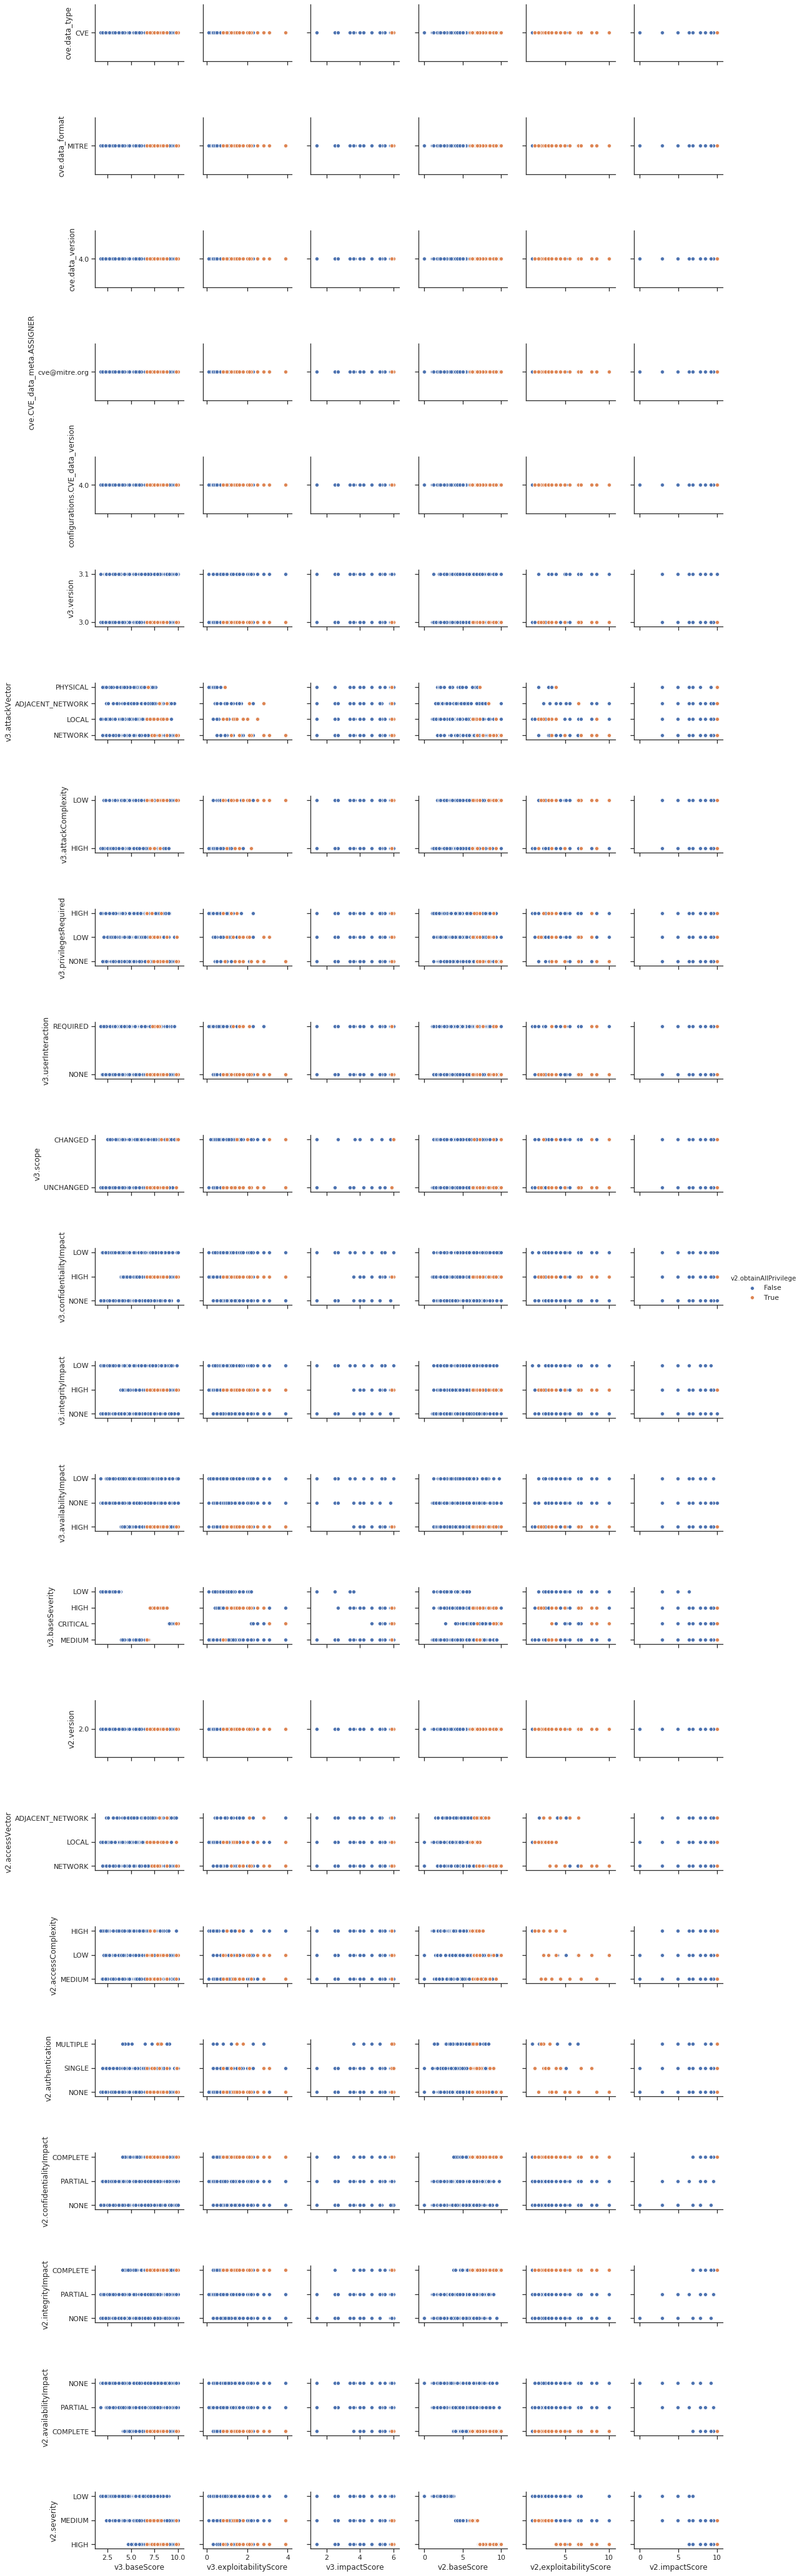

In [430]:

float_cols = nvd_df.select_dtypes(include=['float']).columns
cat_cols = nvd_df.select_dtypes(include=['category']).columns

# sns.pairplot(nvd_df.select_dtypes(include=['float']), )
sns.pairplot( data=nvd_df, x_vars=float_cols, y_vars=cat_cols,hue='v2.obtainAllPrivilege')
plt.show()

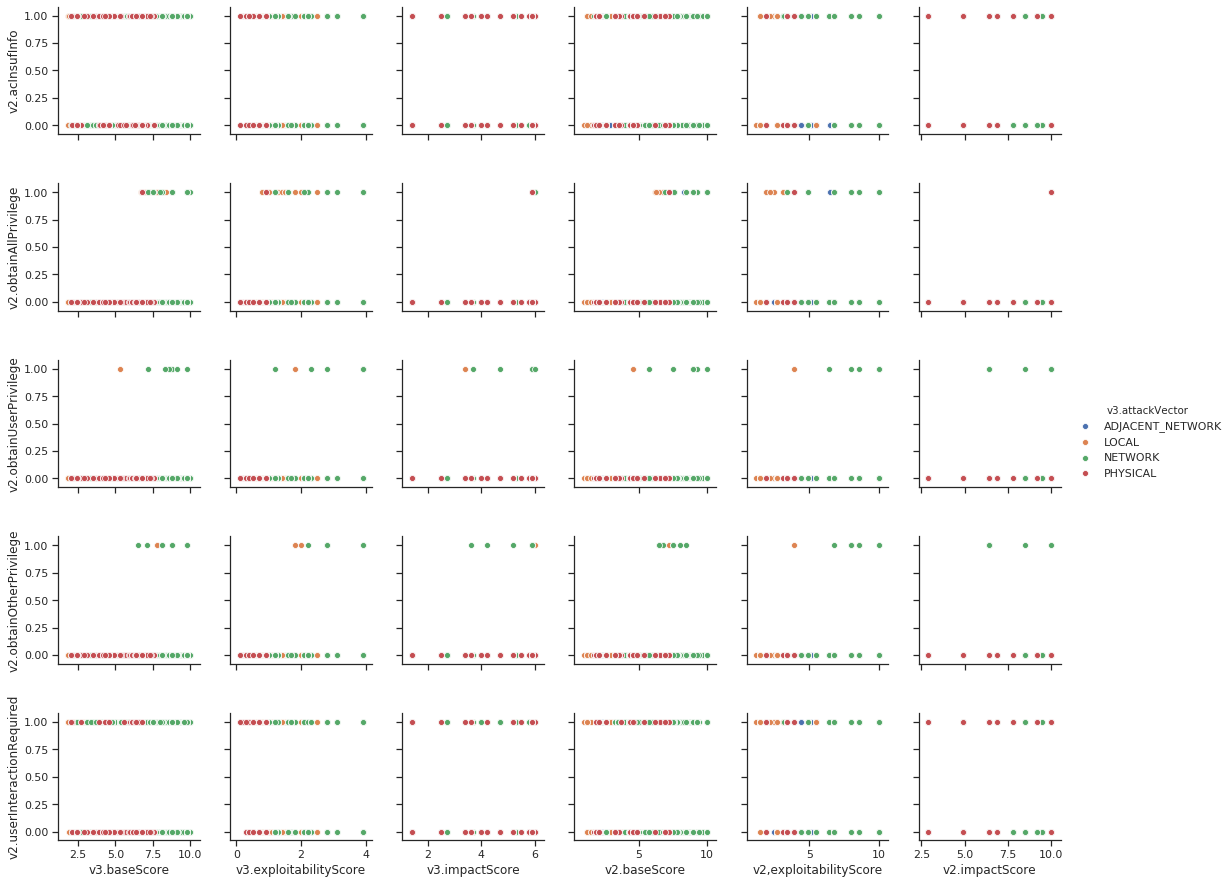

In [428]:

float_cols = nvd_df.select_dtypes(include=['float']).columns
bool_cols = nvd_df.select_dtypes(include=['bool']).columns

# sns.pairplot(nvd_df.select_dtypes(include=['float']), )
sns.pairplot( data=nvd_df, x_vars=float_cols, y_vars=bool_cols,hue='v3.attackVector')
plt.show()

In [435]:
nvd_df.columns

Index(['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes', 'v3.version', 'v3.vectorString',
       'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
       'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
       'v3.integrityImpact', 'v3.availabilityImpact', 'v3.baseScore',
       'v3.baseSeverity', 'v3.exploitabilityScore', 'v3.impactScore',
       'v2.version', 'v2.vectorString', 'v2.accessVector',
       'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
       'v2.integrityImpact', 'v2.availabilityImpact', 'v2.baseScore',
       'v2.severity', 'v2,exploitabilityScore', 'v2.impactScore',
       'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
       'v2.o

In [511]:
# fig, ax = plt.subplots(figsize=(15,7))
# nvd_df.groupby(['v2.accessVector', 'v3.attackVector','publishedDate']).count().ungroup().plot(ax=ax)

nvdAVbyYr = nvd_df.groupby([nvd_df['publishedDate'].dt.year, 'v2.accessVector'])['v2.accessVector'].count()
# nvdAVbyYr.plot(ax=ax)
nvdAVbyYr
# nvdAVbyYr.unstack()

publishedDate  v2.accessVector 
1988           NETWORK                 2
1989           LOCAL                   2
               NETWORK                 1
1990           LOCAL                   8
               NETWORK                 3
                                   ...  
2018           LOCAL                2168
               NETWORK             14077
2019           ADJACENT_NETWORK      290
               LOCAL                2343
               NETWORK             13282
Name: v2.accessVector, Length: 79, dtype: int64

Text(0, 0.5, 'Vuln Count')

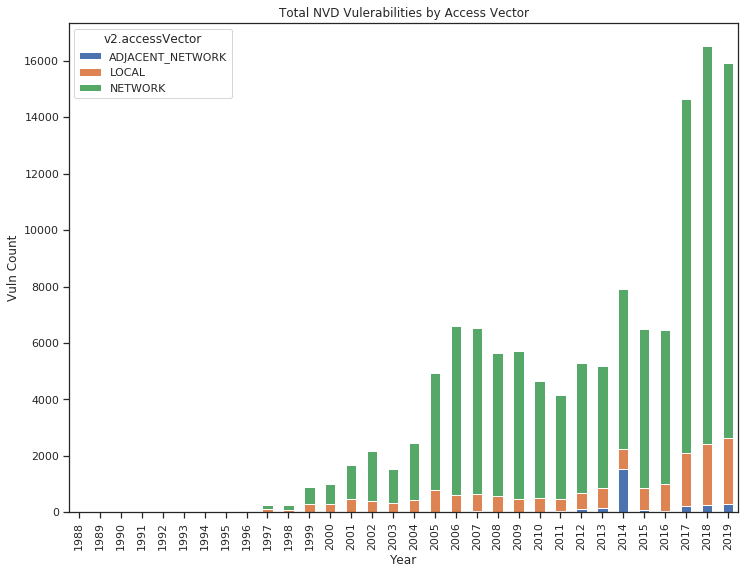

In [519]:
# df_access_vector_group = nvdAVbyYr.groupby(nvdAVbyYr['v2.accessVector'])
# df_access_vector_group

nvd_plot = nvdAVbyYr.unstack().plot(kind='bar',stacked=True,title="Total NVD Vulerabilities by Access Vector",figsize=(12, 9))
nvd_plot.set_xlabel("Year")
nvd_plot.set_ylabel("Vuln Count")